In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

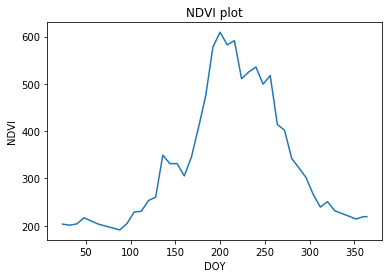

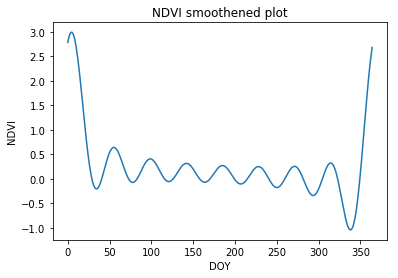

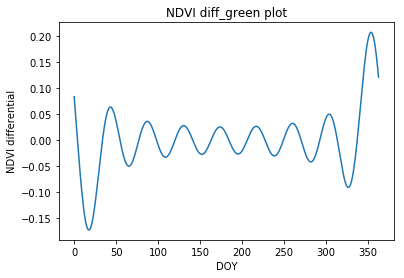

(174, 282)

In [57]:
template=pd.read_csv('template.csv').drop('Unnamed: 0',axis=1)
def crop_phenologies(file_path,crop):
    p=pd.read_csv(file_path).drop("Unnamed: 0",axis=1)
    num_countys=p.shape[0]
    num_days=p.shape[1]-1
    i=0
    num_days_missing=46-num_days
    q=pd.melt(pd.Series.to_frame(p.iloc[i])).drop('variable',axis=1).drop([43],axis=0)
    q.columns=[p.GEOID[i]]
    for i in range(1,num_countys):
        q=pd.concat([q,pd.melt(pd.Series.to_frame(p.iloc[i])).drop('variable',axis=1).drop([43],axis=0)],axis=1)
        q=q.rename(columns = {'value':str(p.GEOID[i])})
    for i in range(num_days_missing):
        q.loc[-1] = [np.nan]*93
        q.index+=1
    q.sort_index(inplace=True)

    df=pd.DataFrame()
    for i in range(len(q)):
        df=pd.concat([df,q.iloc[[i]],template])
    df.index=range(1,1+len(df.index))
    df=df[:365]
    
    if crop=='corn':
            gl=140
            gu=176
            sl=213
            su=305
    elif crop=='soy':
            gl=156
            gu=196
            sl=227
            su=290
    elif crop=='wheat':
            gl=10
            gu=60
            sl=135
            su=196
    
    return get_PTD(pd.Series.to_frame(df.iloc[:,1]),gl,gu,sl,su)

crop_phenologies("county_NDVI_2002_corn.csv",'corn')

In [58]:
import os
import pdb

import numpy as np
import pandas as pd
from scipy.optimize import leastsq


def model_fourier(params, agdd, n_harm):
    """
    Fourier model
    :param params:
    :param agdd:
    :param n_harm:
    :return:
    """
    integration_time = len(agdd)
    t = np.arange(1, integration_time + 1)
    result = t*.0 + params[0]
    w = 1

    for i in range(1, n_harm * 4, 4):
        result = result + params[i] * np.cos(2.0 * np.pi * w * t / integration_time + params[i+1]) \
                 + params[i+2]*np.sin(2.0 * np.pi * w * t / integration_time + params[i+3])
        w += 1

    return result


def mismatch_function(params, func_phenology, ndvi, agdd):
    """
    The NDVI/Phenology model mismatch function
    :param params:
    :param func_phenology:
    :param ndvi:
    :param agdd:
    :param years:
    :return:
    """
    # output stores the predictions
    output = []

    oot = ndvi - func_phenology(params, agdd, n_harm=8)

    [output.append(x) for x in oot]

    return np.array(output).squeeze()


def do_fourier(ndvi, gdd, n_harm=8, init_params=None):
    """
    :param ndvi:
    :param gdd:
    :param n_harm:
    :param init_params:
    :return:
    """
    n_params = 1 + n_harm * 4

    if init_params is None:
        init_params = [.25, ] * n_params
        (xsol, mesg) = leastsq(mismatch_function, init_params, args=(model_fourier, ndvi, gdd), maxfev=1000000)
        model_fitted = model_fourier(xsol, gdd, n_harm)

    return model_fitted


def get_PTD(df,gl,gu,sl,su):
    """
    Get phenological transition dates (greenup, senescence)
    :param df:
    :return:
    """
    # Input dataframe has an index comprised of day of year and remaining columns signify NDVI
    # Linearly interpolate dataframe columns to fill in missing values
    df = df.apply(pd.Series.interpolate)
    plt.plot(list(range(len(df))),df)
    plt.xlabel("DOY")
    plt.ylabel("NDVI")
    plt.title("NDVI plot")
    plt.show()
    
    # Now compute mean of all columns and get the smoothened NDVI
    arr_smooth = do_fourier(df.iloc[:,0], [8.0] * len(df))
    #print(arr_smooth)
    plt.plot(list(range(len(arr_smooth))),arr_smooth)
    plt.xlabel("DOY")
    plt.ylabel("NDVI")
    plt.title("NDVI smoothened plot")
    plt.show()
    
    # For all other crops and regions, take differential
    # To get doy_green, find the last occurrence of the max differential
    diff_green = np.diff(arr_smooth[:365 + 1])
    
    plt.plot(list(range(len(diff_green))),diff_green)
    plt.xlabel("DOY")
    plt.ylabel("NDVI differential")
    plt.title("NDVI diff_green plot")
    plt.show()
    #doy_green = np.where(diff_green == diff_green[gl:gu+1].max())[0][-1]
    #doy_senesc = np.diff(arr_smooth[:365 + 1]).argmin()
    green_indices=np.where(diff_green == diff_green[gl:gu+1].max())[0]
    for i in green_indices:
        if i<=gu and i>=gl:
            doy_green = i
            break
    sen_indices=np.where(diff_green == diff_green[sl:su+1].min())[0]
    for i in sen_indices:
        if i<=su and i>=sl:
            doy_senesc = i
            break
    return doy_green, doy_senesc

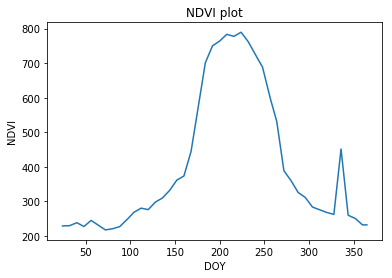

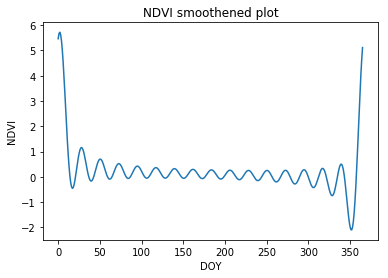

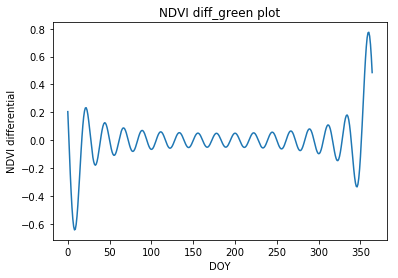

(156, 300)

In [59]:
gl=140
gu=176
sl=213
su=305
get_PTD(pd.Series.to_frame(df.iloc[:,12]),gl,gu,sl,su)